This is a modified Version of Chris's notebook:https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676

In [3]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
# import lightgbm as lgb
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [42]:
train = pd.read_csv('predict-student-performance-from-game-play/train.csv').astype({'level':'int16', 'index': 'int16', 'elapsed_time':'int16','room_coor_x':'float32','room_coor_y':'float32','screen_coor_x':'float32','screen_coor_y':'float32'}).drop(['index','fullscreen','hq','music','name','text'], axis=1)

In [41]:
def df_scale(train):
    # train.drop(['fullscreen', 'hq', 'music'], axis=1, inplace=True)
    train['room_coor_x'] = train['room_coor_x'].fillna(0)
    train['room_coor_y'] = train['room_coor_y'].fillna(0)
    train['screen_coor_x'] = train['screen_coor_x'].fillna(0)
    train['screen_coor_y'] = train['screen_coor_y'].fillna(0)
    train['hover_duration'] = train['hover_duration'].fillna(0)
    train['page'].fillna(-1)
    return train


In [6]:
train = df_scale(train)

In [7]:
targets = pd.read_csv('predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [8]:
from sklearn.preprocessing import OneHotEncoder
items = train['page'].values
labels = items.reshape(-1,1)

oh_page_encoder = OneHotEncoder()

oh_page_encoder.fit(labels)
oh_page_labels = oh_page_encoder.transform(labels)


In [9]:
def oh_page_out(df: pd.DataFrame) -> None:
    train_cat = oh_page_labels.toarray()

    tmp_df = pd.DataFrame(train_cat, columns=[
                          'page_' + str(col) for col in range(-1, 7)]).astype(dtype = 'int8')
    pd.concat([df[['session_id', 'level_group']], tmp_df], axis=1).to_csv("temp/page_train.csv")


In [10]:
oh_page_out(train)

In [11]:
train = train.drop(columns=['page'],axis=1)

In [12]:
train.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'level_group'],
      dtype='object')

# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB! The idea for EVENTS feature is from [here][1]

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [13]:
NUNIQUE = ['event_name','fqid', 'room_fqid']
MMS = ['elapsed_time', 'hover_duration','index'] # mean,std
MEAN = ['level']
STD = ['room_coor_x', 'room_coor_y','screen_coor_x','screen_coor_y']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
SUM = ['index']
PAGE = ['page_-1', 'page_0', 'page_1', 'page_2',
        'page_3', 'page_4', 'page_5', 'page_6']


In [14]:
train.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'level_group'],
      dtype='object')

In [15]:
train['text_fqid'].value_counts() # name 6개, event_name 11개, 

tunic.historicalsociety.cage.confrontation               333363
tunic.wildlife.center.crane_ranger.crane                 235368
tunic.historicalsociety.frontdesk.archivist.newspaper    214637
tunic.historicalsociety.entry.groupconvo                 213592
tunic.wildlife.center.wells.nodeer                       199978
                                                          ...  
tunic.wildlife.center.fox.concern                           111
tunic.drycleaner.frontdesk.block_0                          106
tunic.historicalsociety.entry.gramps.hub                     21
tunic.humanecology.frontdesk.block_1                          8
tunic.drycleaner.frontdesk.block_1                            3
Name: text_fqid, Length: 126, dtype: int64

In [16]:
def feature_engineer(train):
    dfs = []
    for c in NUNIQUE:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    # for c in MMS:
    #     tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
    #     tmp.name = tmp.name + '_mean'
    #     dfs.append(tmp)
    # for c in PAGE:
    #     tmp = train.groupby(['session_id', 'level_group'])[c].agg('sum')
    #     tmp.name = tmp.name + '_sum'
    #     dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in MEAN:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in STD:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in SUM:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
    df = pd.concat(dfs,axis=1)
    # df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [17]:
def feature_engineer_page(train):
    dfs = []
    for c in PAGE:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)

    df = pd.concat(dfs, axis=1)
    # df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df


In [18]:
%%time
train = pd.concat([feature_engineer(train), feature_engineer_page(pd.read_csv('temp/page_train.csv'))], axis=1)


CPU times: user 35.2 s, sys: 4.2 s, total: 39.5 s
Wall time: 40.4 s


In [19]:
train.columns

Index(['level_group', 'event_name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_nunique', 'elapsed_time_max',
       'hover_duration_max', 'index_max', 'elapsed_time_min',
       'hover_duration_min', 'index_min', 'elapsed_time_std',
       'hover_duration_std', 'index_std', 'level_mean', 'room_coor_x_std',
       'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
       'index_sum', 'navigate_click_sum', 'person_click_sum',
       'cutscene_click_sum', 'object_click_sum', 'map_hover_sum',
       'notification_click_sum', 'map_click_sum', 'observation_click_sum',
       'checkpoint_sum', 'elapsed_time_sum', 'level_group', 'page_-1_sum',
       'page_0_sum', 'page_1_sum', 'page_2_sum', 'page_3_sum', 'page_4_sum',
       'page_5_sum', 'page_6_sum'],
      dtype='object')

In [20]:
t_col = ['level_group', 'event_name_nunique', 'fqid_nunique',
 'room_fqid_nunique', 'text_nunique', 'elapsed_time_max',
 'hover_duration_max', 'index_max', 'elapsed_time_min',
 'hover_duration_min', 'index_min', 'elapsed_time_std',
 'hover_duration_std', 'index_std', 'level_mean', 'room_coor_x_std',
 'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
 'index_sum', 'navigate_click_sum', 'person_click_sum',
 'cutscene_click_sum', 'object_click_sum', 'map_hover_sum',
 'notification_click_sum', 'map_click_sum', 'observation_click_sum',
 'checkpoint_sum', 'elapsed_time_sum', 'TRASH_level_group', 'page_-1_sum',
 'page_0_sum', 'page_1_sum', 'page_2_sum', 'page_3_sum', 'page_4_sum',
 'page_5_sum', 'page_6_sum']


In [21]:
train.columns = t_col

In [22]:
train.columns

Index(['level_group', 'event_name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_nunique', 'elapsed_time_max',
       'hover_duration_max', 'index_max', 'elapsed_time_min',
       'hover_duration_min', 'index_min', 'elapsed_time_std',
       'hover_duration_std', 'index_std', 'level_mean', 'room_coor_x_std',
       'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
       'index_sum', 'navigate_click_sum', 'person_click_sum',
       'cutscene_click_sum', 'object_click_sum', 'map_hover_sum',
       'notification_click_sum', 'map_click_sum', 'observation_click_sum',
       'checkpoint_sum', 'elapsed_time_sum', 'TRASH_level_group',
       'page_-1_sum', 'page_0_sum', 'page_1_sum', 'page_2_sum', 'page_3_sum',
       'page_4_sum', 'page_5_sum', 'page_6_sum'],
      dtype='object')

In [23]:
train = train.drop('TRASH_level_group',axis=1)


# Train XGBoost Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [24]:
FEATURES = train.columns[1:]
print(f'{len(FEATURES)}개의 특성')
ALL_USERS = train.index.unique()
print(f'{len(ALL_USERS)}명의 유저 정보')


37개의 특성
11779명의 유저 정보


In [25]:
train = train.reset_index()
train = train.set_index('session_id')


You can also use grid search and Bayesian optimization methods

In [26]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=train, groups=train.index)):
    print('#'*5)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.005,
    'max_depth': 4,
    'n_estimators': 1500,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    }
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = train.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = train.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#####
### Fold 1
#########################


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(1493), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(1352), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(1025), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(1497), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(821), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(949), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(1444), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(904), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(804), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(1404), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(931), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(825), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(1134), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(1380), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(1390), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(944), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(757), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(1261), 
#####
### Fold 2
#########################


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(1497), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(1017), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(1496), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(1340), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(941), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(1067), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(1156), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(595), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(1067), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(1022), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(676), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(726), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(957), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(1084), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(1210), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(694), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(440), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(1034), 
#####
### Fold 3
#########################


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(1497), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(1220), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(1489), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(871), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(687), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(627), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(1222), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(718), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(1304), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(846), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(707), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(857), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(1083), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(1352), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(1333), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(1088), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(724), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(1184), 
#####
### Fold 4
#########################


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(1500), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(1185), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(924), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(998), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(1219), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(1079), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(858), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(405), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(903), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(831), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(911), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(1038), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(635), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(1046), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(1500), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(599), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(648), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(1287), 
#####
### Fold 5
#########################


/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(1270), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(1192), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(1216), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(977), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(559), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(1131), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(1226), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(712), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(1342), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(599), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(869), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(826), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(941), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(1162), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(1499), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(659), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(781), 

/Users/minholee/.pyenv/versions/3.9.4/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(768), 


# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [27]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [28]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

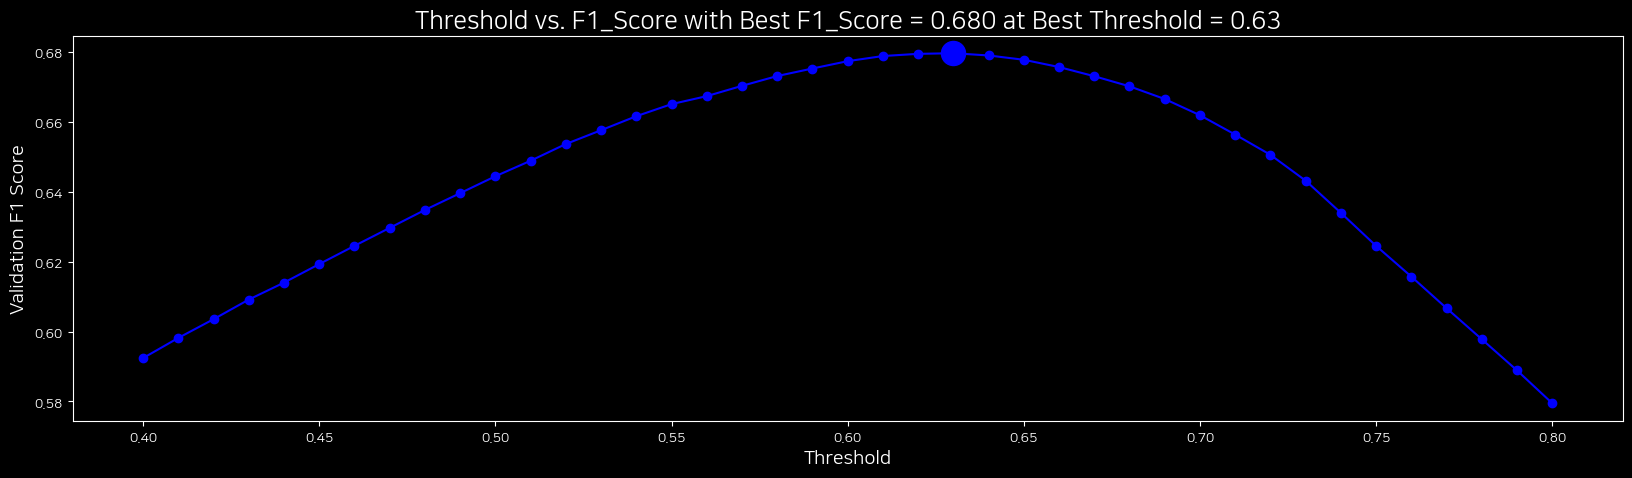

In [29]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [30]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6101293786029617
Q1: F1 = 0.4946153516111039
Q2: F1 = 0.4884978302409976
Q3: F1 = 0.6105165114944187
Q4: F1 = 0.5702713414129015
Q5: F1 = 0.6084865728335219
Q6: F1 = 0.5962677674157814
Q7: F1 = 0.5153900574363431
Q8: F1 = 0.6062675308313091
Q9: F1 = 0.4970096844572176
Q10: F1 = 0.5957770589453784
Q11: F1 = 0.5001494647953529
Q12: F1 = 0.43523297355211477
Q13: F1 = 0.617384058248682
Q14: F1 = 0.5031033883411388
Q15: F1 = 0.4643896617913471
Q16: F1 = 0.5445222069348299
Q17: F1 = 0.49052080932415365
==> Overall F1 = 0.679599210821819


# Infer Test Data

In [54]:
test = pd.read_csv('predict-student-performance-from-game-play/test.csv')
sample_submission = pd.read_csv('predict-student-performance-from-game-play/sample_submission.csv')



In [55]:
def iter_test():
    yield (sample_submission, test)
iter_test = iter_test()

In [56]:
limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}

for (sample_submission, test) in iter_test:
    test = df_scale(test)
    print(test.columns)
    test = test.astype({'level': 'int16', 'index': 'int16', 'elapsed_time': 'int16', 'room_coor_x': 'float32', 'room_coor_y': 'float32',
                       'screen_coor_x': 'float32', 'screen_coor_y': 'float32'}).drop(['index', 'fullscreen', 'hq', 'music', 'name', 'text'], axis=1)
    oh_page_out(test)
    test = test.drop(columns=['page'], axis=1)


    # FEATURE ENGINEER TEST DATA
    test = pd.concat([feature_engineer(test), feature_engineer_page(
        pd.read_csv('temp/page_train.csv'))], axis=1)

    test.columns = t_col

    test = test.drop('TRASH_level_group', axis=1)
    test = test.reset_index()
    test = test.set_index('session_id')

    # INFER TEST DATA
    grp = test.level_group.values[0]
    a, b = limits[grp]
    for t in range(a, b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:, 1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask, 'correct'] = int(p.item() > best_threshold)

    print(sample_submission)

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'session_level'],
      dtype='object')


KeyError: 'Column not found: text'

# EDA submission.csv

In [44]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

In [ ]:
print(df.correct.mean())

0.5370370370370371
